In [30]:
ion1 = -4
ion2 = 4
nions = 13
nseg = 25
file_suffix = "v1"

# Optimizer settings
pitime = 8  # us, corresponds to max rabi frequency per base function
τmin = 5    # min segment length in us
τmax = 15   # max segment length in us
maxtime = 10  # max seconds to run optimization
min_mode_index = 1  # lower bound for detune during gate 
max_mode_index = 2  # max bound for detune during gate 
params_file = "../system_params/072125_goldparams_13ions.json"
println("Gate time between $(τmin * nseg) and $(τmax * nseg) μs")
println("Lower bound on pi time required: $(pitime/cld(nseg+1, 2)) μs")

Gate time between 125 and 375 μs
Lower bound on pi time required: 0.6153846153846154 μs


In [31]:
using GoldGates
using MSSim: Optimizers as Opts, SegSeq as SS, SymLinear as SL, Sequence as Seq, Utils as U
using NLopt
using Statistics
using PyPlot
using JSON
using Dates

include("../src/utils.jl")
ENV["MPLBACKEND"] = "module://matplotlib_inline.backend_inline"

sysparams = open(params_file) do io
    read(io, GoldGates.SystemParams; format=:json)
end

modes = setup_modes(sysparams, ion1, ion2, nions)
nlmodel = setup_model(nseg, modes)
opt, tracker = setup_optimizer(nlmodel, sysparams; pitime, τmin, τmax, maxtime, min_mode_index, max_mode_index)

date = Dates.format(Dates.now(), "yyyymmdd")
out_file = "../out/$(date)_am_$(nions)_$(file_suffix).json"
println("Results will be saved to $out_file")

best_params, best_obj = run_optimization!(opt, tracker, nlmodel)

Results will be saved to ../out/20260208_am_13_v1.json
(obj = 246.74011002723395, dis = 0.0, disδ = 0.0, area = 0.0, areaε = -1.5707963267948966, areaδ = 0.0, total_t = 125.30051716468442, Ωmax = 0.0)
(obj = 0.09004106395797286, dis = 0.00017094489650093446, disδ = 8.91705328698291, area = 1.5705096704117918, areaε = -0.0002866563831047664, areaδ = 27.548897331126213, total_t = 253.6982339767088, Ωmax = 4.145347401750111e-5)
(obj = 0.007697923088304367, dis = 7.210135289570813e-6, disδ = 0.7660411328732308, area = 1.5707718191716666, areaε = -2.4507623229919062e-5, areaδ = 11.836472297799476, total_t = 366.29063853626985, Ωmax = 0.000891173732878295)
(obj = 0.006060503384151299, dis = 3.2016470339314493e-6, disδ = 0.6035831531115559, area = 1.5706711746535964, areaε = -0.0001251521413001555, areaδ = 26.640780804778704, total_t = 291.93626019014005, Ωmax = 0.00012173249969913681)
(obj = 0.0060605033830986674, dis = 3.201646493012258e-6, disδ = 0.6035831534025259, area = 1.57067117470368

([11.677450408815119, 0.00012173251860451233, 0.017333242552371207, 0.047018278433450335, 0.07319545218940715, 0.08723342728390358, 0.11873683084172114, 0.16450670875652348, 0.19634954084936207, 0.19488957898256612, 0.1717875649021566, 0.14843111149111038, 0.12772933332926872, 0.08323354463018086, 14.259197663378325], 0.0060605033830986674)

┌ Warning: displacement_at_+1kHz = 0.7217 (<= 0.05)
└ @ Main ~/Documents/git/GoldGates.jl/src/utils.jl:245
┌ Warning: displacement_at_-1kHz = 0.7217 (<= 0.05)
└ @ Main ~/Documents/git/GoldGates.jl/src/utils.jl:245


Saved solution for ions (-4, 4) to ../out/20260208_am_13_v1.json


┌ Warning: carrier_pi_time_required = 1.098 (>= 2.7)
└ @ Main ~/Documents/git/GoldGates.jl/src/utils.jl:245
┌ Warning: gradient_displacement_detuning = 0.6036 (<= 0.001)
└ @ Main ~/Documents/git/GoldGates.jl/src/utils.jl:245
┌ Warning: total_cumulative_displacement = 0.6036 (<= 0.001)
└ @ Main ~/Documents/git/GoldGates.jl/src/utils.jl:245


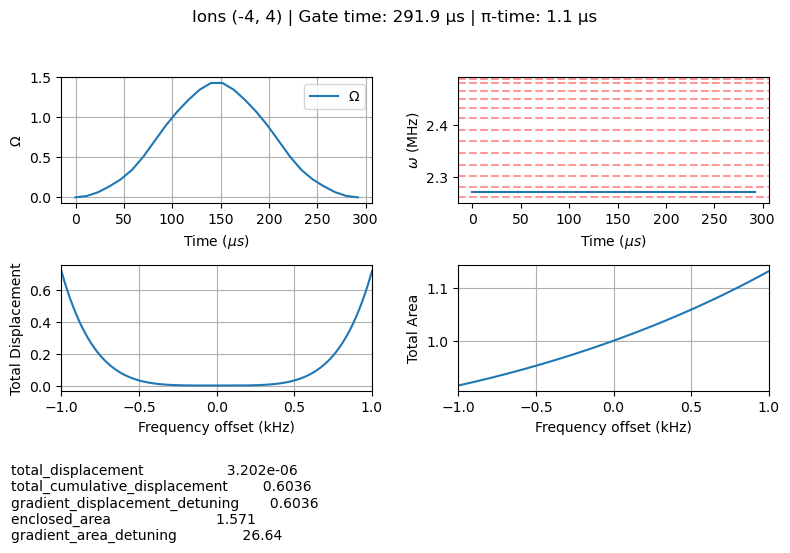

In [32]:
# === Review results & save ===
opt_raw_params, metadata = get_metadata_and_plot(nlmodel, best_params, nseg, sysparams, modes;
    ion1, ion2, pitime, τmin, τmax, maxtime, min_mode_index, max_mode_index)
verify_solution(metadata)
save_am_solution(out_file, opt_raw_params, metadata, sysparams, ion1, ion2)